In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# http://seaborn.pydata.org/generated/seaborn.set.html
sns.set(style='white', context='notebook', palette='deep')

In [3]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

(42000,)
(42000, 784)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

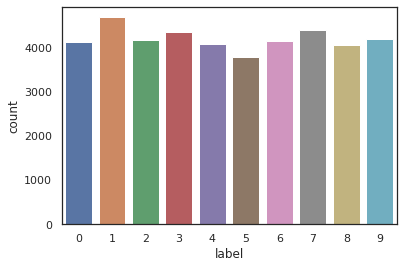

In [4]:
# 'label'
Y_train = train["label"]
print(Y_train.shape)


X_train = train.drop(labels = ["label"],axis = 1) 
print(X_train.shape)


del train


# https://seaborn.pydata.org/generated/seaborn.countplot.html?highlight=countplot
g = sns.countplot(Y_train)


# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html
Y_train.value_counts()

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
X_train = X_train / 255.0
test = test / 255.0

In [8]:
#(height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
#2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
random_seed = 2

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

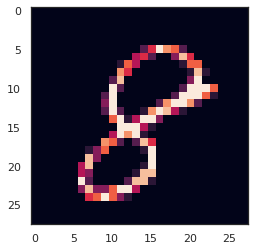

In [11]:
g = plt.imshow(X_train[0][:,:,0])

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        2

In [13]:

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
epochs = 30
# epochs = 30 
batch_size = 86

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  				
        samplewise_center=False,  				
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,  	
        zca_whitening=False,  					
        rotation_range=10,  					
        zoom_range = 0.1, 						
        width_shift_range=0.1,  				
        height_shift_range=0.1,  				
        horizontal_flip=False,  				
        vertical_flip=False)  				


datagen.fit(X_train)

In [17]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
439/439 - 154s - loss: 0.3659 - accuracy: 0.8911 - val_loss: 0.1480 - val_accuracy: 0.9531
Epoch 2/30
439/439 - 153s - loss: 0.1397 - accuracy: 0.9600 - val_loss: 0.0572 - val_accuracy: 0.9840
Epoch 3/30
439/439 - 158s - loss: 0.1109 - accuracy: 0.9677 - val_loss: 0.0422 - val_accuracy: 0.9874
Epoch 4/30
439/439 - 155s - loss: 0.0921 - accuracy: 0.9737 - val_loss: 0.1050 - val_accuracy: 0.9721
Epoch 5/30
439/439 - 155s - loss: 0.0815 - accuracy: 0.9780 - val_loss: 0.0319 - val_accuracy: 0.9895
Epoch 6/30
439/439 - 155s - loss: 0.0761 - accuracy: 0.9789 - val_loss: 0.0299 - val_accuracy: 0.9924
Epoch 7/30
439/439 - 157s - loss: 0.0778 - accuracy: 0.9785 - val_loss: 0.0467 - val_accuracy: 0.9876
Epoch 8/30
439/439 - 155s - loss: 0.0631 - accuracy: 0.9816 - val_loss: 0.0396 - val_accuracy: 0.9900
Epoch 9/30
439/439 - 155s - loss: 0.0593 - accuracy: 0.9840 - val_loss: 0.0277 - val_accuracy: 0.9926
Epoch 10/30
439/439 - 155s - loss: 0.0588 - accuracy: 0.9836 - val_loss: 0.0288 - 

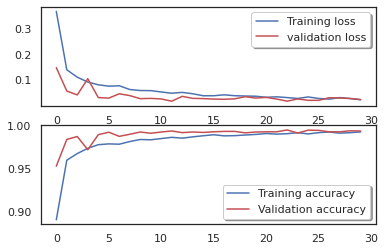

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

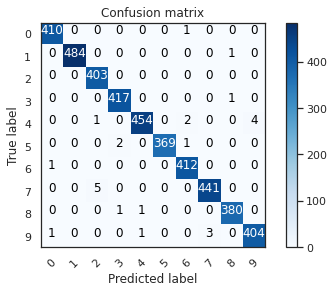

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Y_pred = model.predict(X_val)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(10))

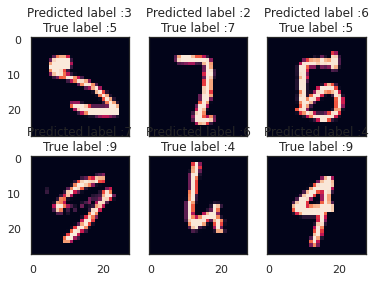

In [20]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """
    """
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1


Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)


true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))


delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors


sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6
most_important_errors = sorted_dela_errors[-6:]


display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [21]:
results = model.predict(test)

results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [22]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)


submission.to_csv("Abhi_mnist_datagen.csv",index=False)